# Assess Opportunitites for PPC Automation - AT&T

by `Xiaoli Qiu`

Created: `2021-12-20`. <br>

JIRA: https://clearlink.atlassian.net/browse/ONE-7859.

Date range: ['2021-09-26', '2021-12-11'] (Sunday, Saturday). Look at call arrival patterns for ATT PPC campaigns (brand_marketed = 'ATT'), look at gross calls, queue opps, abandon calls (/answer rates), IVR overflow versus queue overflow etc.

Overflow abandon codes:
- Prequeue: [490, 491, 493, 494, 495, 626, 700, 704].
- Queue: [322, 637, 638, 639, 640, 641, 699]. 

Note: Vivint: 699 (queue) & 700 (non-queue); Updater: 704. Other abandon codes: IBEX (322 & 626 being default/everything else). 

AT&T doesn't have dynamic overflow inplace, hence, pre-queue overflow should not be influenced by the call volume or agent availability. However, queueue overflow is influenced by call volume and agent availability. <br>


## Contents
1. <a href='#read_data'> Read Data </a> <br>
2. <a href='#groupdata'> Aggregate Data on A 15-Min Rolling Windwow </a> <br>
    2.1. <a href='#low_ans_plots'> Plots - Low Answer Rate </a> <br>
3. <a href='#callbacks'> Callbacks from Abandoned/Overflowed Calls </a> <br>
    3.1. <a href='#marketing_costs_conclusion'> Conclusion for Lost Calls and the Associated Marketing Costs </a> <br>
4. <a href='#agent_call_q'> Agent Availability & Calls in Queue </a> <br>
5. <a href='#summary'> Summary </a> <br>


In [259]:
import datetime
print('Last time updated: ', datetime.datetime.now())

Last time updated:  2022-01-11 13:48:00.399635


In [2]:
import pandas as pd
import numpy as np 

In [3]:
import seaborn as sns

import plotly.express as px
import plotly.io as pio

%matplotlib inline

In [4]:
import plotly.graph_objs as go
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected = True)
cf.go_offline()

In [5]:
#style definition
sns.set_theme(style="darkgrid")
sns.set_palette("hls")
# sns.set_style("whitegrid")
import matplotlib.pyplot as plt  
plt.style.use('dark_background')

pio.templates.default = "plotly_dark"

In [6]:
# Set universal font size
plt.rcParams.update({'font.size': 20})

In [8]:
# import psycopg2

In [9]:
# con = psycopg2.connect(dbname = 'datawarehouse', host ='dw_prod.clearlinkdata.com', 
#                        port = '5439', user = username, password = password)

# con = psycopg2.connect(dbname = 'datawarehouse_stage', host ='dw_stage.clearlinkdata.com', 
#                        port = '5439', user = username, password = password)

# Functions

In [19]:
def agg_datetime(df, freq='15min'):
    """
    Aggregate the data by the given frequency (in time)
    :param df: dataframe used for aggregation
    :param freq: time window for aggregation. Default: 15 mins. 
    :param PPC_only: look at PPC campaigns only by default (1), else look at all campaigns
    :return: dataframe with calls aggregated into different categories
    """
    
    df = df.copy(deep=True)
    
    # pre-queue overflow (IVR, ABP)
    df['prequeue_overflow'] = '0'
    df['prequeue_overflow'] = np.where((df['queue_opp']==0)&(df['abandon_code'].isin([490, 491, 493, 494, 495, 626])), 'IBEX', df['prequeue_overflow'])
    df['prequeue_overflow'] = np.where((df['queue_opp']==0)&(df['abandon_code'].isin([700])), 'Vivint', df['prequeue_overflow'])
    df['prequeue_overflow'] = np.where((df['queue_opp']==0)&(df['abandon_code'].isin([704])), 'Updater', df['prequeue_overflow'])
    
    # queue overflow
    df['queue_overflow'] = '0'
    df['queue_overflow'] = np.where((df['queue_opp']==1)&(df['abandon_code'].isin([322, 637, 638, 639, 640, 641])), 'IBEX', df['queue_overflow'])
    df['queue_overflow'] = np.where((df['queue_opp']==1)&(df['abandon_code'].isin([699])), 'Vivint', df['queue_overflow'])
    
    df.loc[(df['queue_opp']==0)&(df['prequeue_overflow']!='0'), 'call_conclusion'] = 'prequeue_overflow'
    df.loc[(df['queue_opp']==1)&(df['queue_overflow']!='0'), 'call_conclusion'] = 'queue_overflow'
    
    # group calls and calculate the metrics
    df_grouped = df.groupby([pd.Grouper(key='date_prequeue_start', freq=freq), 'campaign', 'queue_opp', 
                             'call_conclusion', 'prequeue_overflow', 'queue_overflow']).agg({'contact_id': lambda x: x.nunique(), 
                                                                                             'cost_marketing': 'sum',
                                                                                             'fkrs_revenue': 'sum', 
                                                                                             'is_converted': 'sum'
                                                                                            }).reset_index()
    df_grouped.rename(columns={'contact_id': 'call_counts', 'is_converted': 'converted_counts' }, inplace=True)
    df_grouped['call_conclusion_%'] =  100* df_grouped['call_counts']/df_grouped.groupby(['date_prequeue_start', 'campaign', 'queue_opp'])['call_counts'].transform('sum')

    
    return [df, df_grouped]
    

In [20]:
def plot_queque_vs_nonqueue(df, datetime_start='2021-11-30 06:00:00', datetime_end='2021-11-30 22:00:00'):
    """
    Plot call counts of queue opps versus that of non-queue-opps
    :param df: input dataframe with aggregated data
    :param datetime_start: start time for the plot, default: '2021-11-30 06:00:00'
    :param datetime_end: end time for the plot, default: '2021-11-30 22:00:00'
    :return: plot
    """
    fig = px.pie(df, values='call_counts', names='queue_opp')
    # fig.update_traces(textposition='inside', textinfo='percent+label')
    fig.update_layout(legend = dict(bgcolor = 'LightSteelBlue'), title= 'Call Distributions')
    fig.show()
    

In [21]:
def plot_call_conclusions(df, datetime_start='2021-11-30 06:00:00', datetime_end='2021-11-30 22:00:00', queue_opp=1, thresh=30, top=3):
    """
    Plot the data in the given time window
    :param df: input dataframe with aggregated data
    :param datetime_start: start time for the plot, default: '2021-11-30 06:00:00'
    :param datetime_end: end time for the plot, default: '2021-11-30 22:00:00'
    :param queue_opp: plot queue opps only (1, default) or non-quque_opp (0) or both (2)
    :param thresh: threshold of call counts, don't include the campaign if number of calls for th grouping frequency is less than the threshold
    :param top: top n (given) campaigns in terms of call volume
    :return: a time-series plot with various call conlusion percentage rates
    """
    df = df[df['date_prequeue_start'].between(datetime_start, datetime_end)].copy(deep=True)
    df = df.groupby(by=['date_prequeue_start', 'campaign', 'queue_opp', 'call_conclusion']).agg({'call_counts': 'sum', 'call_conclusion_%': 'sum'}).reset_index()
    
    if queue_opp == 1: 
        df = df[df['queue_opp']==1].copy(deep=True)
        if thresh is not None:
            df_cam = df.groupby(by=['date_prequeue_start', 'campaign']).agg({'call_counts': 'sum'}).reset_index()
            df_cam = df_cam[df_cam['call_counts']>=thresh].copy(deep=True)
            df = pd.merge(df, df_cam[['date_prequeue_start', 'campaign']] , how='right', on=['date_prequeue_start', 'campaign'])
        elif top is not None:
            l_campaigns = df.groupby(by=['campaign']).agg({'call_counts': 'sum'}).reset_index().sort_values(by=['call_counts'], 
                                                                                                            ascending=[False])['campaign'].unique().tolist()[:top]
            df = df[df['campaign'].isin(l_campaigns)].copy(deep=True)
        
        fig = px.line(df, x="date_prequeue_start", y="call_conclusion_%",
                      color="call_conclusion", facet_col='campaign', hover_data=[df.index], markers=True, facet_col_wrap=1,
                      facet_row_spacing=0.08)
        fig.update_layout(legend = dict(bgcolor = 'LightSteelBlue'), title= 'QueueOpps Call Conclusion Percentage Rates over Time')
        fig.update_yaxes(matches='y')
        fig.show()
    
    elif queue_opp == 0:
        df = df[df['queue_opp']==0].copy(deep=True)
        if thresh is not None:
            df_cam = df.groupby(by=['date_prequeue_start', 'campaign']).agg({'call_counts': 'sum'}).reset_index()
            df_cam = df_cam[df_cam['call_counts']>=thresh].copy(deep=True)
            df = pd.merge(df, df_cam[['date_prequeue_start', 'campaign']] , how='right', on=['date_prequeue_start', 'campaign'])
        elif top is not None:
            l_campaigns = df.groupby(by=['campaign']).agg({'call_counts': 'sum'}).reset_index().sort_values(by=['call_counts'], 
                                                                                                            ascending=[False])['campaign'].unique().tolist()[:top]
            df = df[df['campaign'].isin(l_campaigns)].copy(deep=True)
            
        fig = px.line(df, x="date_prequeue_start", y="call_conclusion_%",
                    color="call_conclusion", facet_row='campaign', hover_data=[df.index], markers=True)
        fig.update_layout(legend = dict(bgcolor = 'LightSteelBlue'), title= 'None-QueueOpps Call Conclusion Percentage Rates over Time')
        fig.update_yaxes(matches='y')
        fig.show()
    elif queue_opp == 2:
        if thresh is not None:
            df_cam = df.groupby(by=['date_prequeue_start', 'campaign']).agg({'call_counts': 'sum'}).reset_index()
            df_cam = df_cam[df_cam['call_counts']>=thresh].copy(deep=True)
            df = pd.merge(df, df_cam[['date_prequeue_start', 'campaign']] , how='right', on=['date_prequeue_start', 'campaign'])
        elif top is not None:
            l_campaigns = df.groupby(by=['campaign']).agg({'call_counts': 'sum'}).reset_index().sort_values(by=['call_counts'], 
                                                                                                            ascending=[False])['campaign'].unique().tolist()[:top]
            df = df[df['campaign'].isin(l_campaigns)].copy(deep=True)
            
        df = df.groupby(by=['date_prequeue_start', 'queue_opp', 'call_conclusion']).agg({'call_counts': 'sum', 'call_conclusion_%': 'mean'}).reset_index()
        fig = px.line(df, x="date_prequeue_start", y="call_conclusion_%",
                    color="call_conclusion", facet_col="queue_opp", hover_data=[df.index], markers=True)
        fig.update_layout(legend = dict(bgcolor = 'LightSteelBlue'), title= 'Call Conclusion Percentage Rates over Time')
        fig.update_yaxes(matches='y')
#         fig.update_yaxes(matches=None)
#         fig.for_each_yaxis(lambda yaxis: yaxis.update(showticklabels=True))
        fig.show()
        
    else:
        print('Wrong queue_opp selection, please select 1 to plot queue opps only, 0 for non- queue ppps, 2 for both. ')

In [256]:
def plot_q_hist_low_ans_rate_m2m(df, datetime_start='2021-11-30 06:00:00', datetime_end='2021-11-30 22:00:00', top=3, anr_thresh=75, m2m=1, pdf=1):
    """
    Plot histogram of time periods where answer rate is low in a given time window
    :param df: input dataframe with aggregated data
    :param datetime_start: start time for the plot, default: '2021-11-30 06:00:00'
    :param datetime_end: end time for the plot, default: '2021-11-30 22:00:00'
    :param top: top n (given) campaigns in terms of call volume
    :param anr_thresh: threshold for answer rate
    :return: a time-series plot where the answer rate (queue opp) is less than the given threshold (anr_thresh)
    """
    df = df[(df['date_prequeue_start'].between(datetime_start, datetime_end)) & (df['queue_opp']==1)].copy(deep=True)
    df = df.groupby(by=['date_prequeue_start', 'campaign', 'call_conclusion']).agg({'call_counts': 'sum', 'call_conclusion_%': 'sum'}).reset_index()
    
    if top is not None:
        l_campaigns = df.groupby(by=['campaign']).agg({'call_counts': 'sum'}).reset_index().sort_values(by=['call_counts'], 
                                                                                                        ascending=[False])['campaign'].unique().tolist()[:top]
        df = df[df['campaign'].isin(l_campaigns)].copy(deep=True)
    
    df_low_anr = df[(df['call_conclusion']=='Answered') & (df['call_conclusion_%']<=anr_thresh)][['date_prequeue_start', 'campaign']]
    df = pd.merge(df_low_anr, 
                  df, 
                  how='left', 
                  on=['date_prequeue_start', 'campaign'])
    
    df['month_prequeue'] = df['date_prequeue_start'].dt.month
    df['time_prequeue'] = df['date_prequeue_start'].dt.time
    
    if pdf==1:
        hist_norm = 'probability density'
        txt = "Probability Density"
    else:
        hist_norm = None
        txt = "Count"
    
    if m2m == 1:
        df = df.sort_values(by=['time_prequeue', 'month_prequeue'], ascending=[True, True])
        fig = px.histogram(data_frame=df, x='time_prequeue', histnorm=hist_norm, facet_col='campaign', facet_row='month_prequeue',
                          category_orders={"month_prequeue": [9, 10, 11, 12], 'time_prequeue': df['time_prequeue'].unique()})
        fig.for_each_annotation(lambda a: a.update(text=a.text.replace("month_prequeue=", "")))
        fig.for_each_annotation(lambda a: a.update(text=a.text.replace("campaign=", "")))
        fig.for_each_yaxis(lambda y: y.update(title = ''))
        fig.add_annotation(x=-0.05,y=0.5,
                           text=txt, textangle=-90,
                            xref="paper", yref="paper")
        fig.update_yaxes(matches='y')
        fig.show()
    else: 
        df = df.sort_values(by=['time_prequeue'])
        fig = px.histogram(data_frame=df, x='time_prequeue', histnorm=hist_norm, facet_col='campaign', marginal = 'box', 
                           category_orders={'time_prequeue': df['time_prequeue'].unique()})
        fig.for_each_annotation(lambda a: a.update(text=a.text.replace("campaign=", "")))
        fig.for_each_yaxis(lambda y: y.update(title = ''))
        fig.add_annotation(x=-0.05,y=0.5,
                           text=txt, textangle=-90,
                            xref="paper", yref="paper")
        fig.update_yaxes(matches='y')
        fig.show()
    
    

In [174]:
def agg_callbacks(df):
    """
    Aggregate callbacks, calculate possible revenue. 
    :param df: dataframe containing un-answered queue opps 
    :return: 
    """
    # rank calls from the same ani (earlist being rank of 1)
    df['rank_ani'] = df.groupby(by=['ani'])['date_prequeue_start'].rank("dense",ascending=True)
    
    # the ANIs/customers whose 1st call got overflowed in queue
    l_q_overflow = df[(df['rank_ani']==1) & (df['queue_opp']==1) & (df['call_conclusion'] == 'queue_overflow')]['ani'].unique().tolist()
    l_q_overflow_conv = df[df['ani'].isin(l_q_overflow) & (df['is_converted']==1) & (df['rank_ani']==1)]['ani'].unique().tolist()
    # Amonog those, # of customers who had called back
    l_q_overflow_cb = df[(df['ani'].isin(l_q_overflow)) & (df['rank_ani'] >=2)]['ani'].unique().tolist()
    # Among those who called back, # of customers that got answered on a subsequent call
    l_q_overflow_ans = df[(df['ani'].isin(l_q_overflow_cb)) & (df['rank_ani'] >=2) & (df['call_conclusion']=='Answered')]['ani'].unique().tolist()
    
    # the ANIs/customers whose 1st call was abandoned in queue
    l_q_abd = df[(df['rank_ani']==1) & (df['queue_opp']==1) & (df['call_conclusion'] == 'Abandoned')]['ani'].unique().tolist()
    # Amonog those, # of customers who had called back
    l_q_abd_cb = df[(df['ani'].isin(l_q_abd)) & (df['rank_ani'] >=2)]['ani'].unique().tolist()
    # Among those who called back, # of customers that got answered on a subsequent call
    l_q_abd_ans = df[(df['ani'].isin(l_q_abd_cb)) & (df['call_conclusion']=='Answered')]['ani'].unique().tolist()
    
    return [l_q_overflow, l_q_overflow_conv, l_q_overflow_cb, l_q_overflow_ans, l_q_abd, l_q_abd_cb, l_q_abd_ans]

    

In [10]:
get_data = """
SELECT cd.contact_id,
       cd.ani,
       cd.brand_skilled,
       cd.skill,
       cd.skill_name,
       cd.campaign,
       cd.call_type,
       cd.call_purpose,
       cd.call_category,
       cd.call_conclusion,
       case
           when is_queue_opp = true and call_purpose in ('Sales', 'External Transfer', 'Internal Transfer') then 1
           else 0 end                                                              as queue_opp,
       case 
            when cd.abandon_code = 1 
                and cd.call_type = 'I' 
                and cd.call_purpose in ('Sales','External Transfer',
                                        'Internal Transfer') then 1 
            else 0 end as answered_call, 
       cd.abandon_code,
       cd.abandon_code_name,
       cd.transfer_code_sending,
       cd.transfer_code_sending_name,
       cd.transfer_code_receiving,
       cd.transfer_code_receiving_name,
       cd.cpr_priority,
       cd.call_priority,
       cd.promo_code,
       cd.marketing_tier,
       cd.sub_channel,
       cd.channel,
       cd.vertical_marketed,
       cd.language_marketed,
       cd.affiliate_id,
       cd.domain,
       cd.ppc_type,
       cd.ppc_ad_group,
       cd.ppc_campaign,
       cd.ppc_account,
       cd.ppc_provider,
       cd.ppc_keyword_description,
       cd.ppc_is_click_to_call,
       cd.ppc_search_intent,
       cd.date_prequeue_start,
       cd.date_prequeue_end,
       cd.date_ivr_start,
       cd.date_ivr_end,
       cd.date_queue_start,
       cd.date_queue_end,
       cd.date_call_start,
       cd.date_call_end,
       cd.call_release,
       cd.is_internal_overflow,
       cd.brand_call_detail,
       cd.date_call_entered,
       cd.date_sort_prequeue_start,
       cd.hold_time,
       cd.handle_time,
       cd.cost_marketing,
       CASE
           WHEN SUM(CASE
                        WHEN ou.orders_id > 0
                            AND o.date_order_scheduled > 0 THEN 1
                        ELSE 0
               END) > 0 THEN 1
           ELSE 0
           END                                                                     AS is_converted,
       sum(COALESCE(fkrs.revenue_gross, 0) + COALESCE(fkrs.revenue_chargeback, 0) +
           COALESCE(fkrs.revenue_activation, 0) + COALESCE(fkrs.revenue_bonus, 0)) AS fkrs_revenue
FROM data_warehouse.call_detail cd
         LEFT JOIN data_warehouse.match_orders_calls moc ON moc.contact_id = cd.contact_id
    AND moc.order_action = 'Scheduled'
         LEFT JOIN data_warehouse.orders o ON moc.orders_id = o.id
         LEFT JOIN data_warehouse.orders_units ou ON ou.orders_id = o.id AND ou.unit_type = 'Service'
         LEFT JOIN data_warehouse.finance_kpi_revenue_orders_units fkrs ON fkrs.id = ou.id
WHERE cd.brand_marketed IN ('ATT')
  AND cd.channel = 'Pay Per Click'
  AND cd.date_sort_prequeue_start BETWEEN '{start_date}' AND '{end_date}'
  AND cd.call_type = 'I'
  AND cd.call_purpose IN ('Sales', 'Customer Service','Internal Transfer', 'External Transfer')
GROUP BY cd.contact_id, cd.ani, cd.brand_skilled, cd.skill, cd.skill_name, cd.campaign, cd.call_type, 
         cd.call_purpose, cd.call_category, cd.call_conclusion, is_queue_opp, cd.abandon_code, 
         cd.abandon_code_name, cd.transfer_code_sending, cd.transfer_code_sending_name, 
         cd.transfer_code_receiving, cd.transfer_code_receiving_name, cd.cpr_priority, 
         cd.call_priority, cd.promo_code, cd.marketing_tier, cd.sub_channel, cd.channel, 
         cd.vertical_marketed, cd.language_marketed, cd.affiliate_id, cd.domain, cd.ppc_type, 
         cd.ppc_ad_group, cd.ppc_campaign, cd.ppc_account, cd.ppc_provider, cd.ppc_keyword_description, 
         cd.ppc_is_click_to_call, cd.ppc_search_intent, cd.date_prequeue_start, cd.date_prequeue_end, 
         cd.date_ivr_start, cd.date_ivr_end, cd.date_queue_start, cd.date_queue_end, cd.date_call_start, 
         cd.date_call_end, cd.call_release, cd.is_internal_overflow, cd.brand_call_detail, cd.date_call_entered, 
         cd.date_sort_prequeue_start, cd.hold_time, cd.handle_time, cd.cost_marketing
ORDER BY cd.contact_id;
"""

<a id = 'read_data'> </a>
# Read Data

In [11]:
# df = pd.read_sql_query(get_data.format(start_date= '2021-09-26', end_date= '2021-12-21'), con)

In [12]:
# df.to_pickle('ATT_PPC_Opportunity_Aug1st_to_Nov30.pkl')
# df.to_pickle('ATT_PPC_Opportunity_Sep26_to_Dec21.pkl')

In [13]:
# df = pd.read_pickle('ATT_PPC_Opportunity_Aug1st_to_Nov30.pkl')
df = pd.read_pickle('ATT_PPC_Opportunity_Sep26_to_Dec21.pkl')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513747 entries, 0 to 513746
Data columns (total 54 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   contact_id                    513747 non-null  int64         
 1   ani                           513747 non-null  int64         
 2   brand_skilled                 513747 non-null  object        
 3   skill                         513747 non-null  int64         
 4   skill_name                    513747 non-null  object        
 5   campaign                      513747 non-null  object        
 6   call_type                     513747 non-null  object        
 7   call_purpose                  513747 non-null  object        
 8   call_category                 513747 non-null  object        
 9   call_conclusion               513747 non-null  object        
 10  queue_opp                     513747 non-null  int64         
 11  answered_call

In [15]:
df['contact_id'].nunique()

512922

In [16]:
df['brand_skilled'].value_counts()/(df['brand_skilled'].value_counts().sum())

ATT     0.956813
ATTW    0.021962
DTV     0.009150
ATTB    0.005843
        0.004960
CL      0.001057
VSAT    0.000113
VIV     0.000031
EMB     0.000023
FTR     0.000019
VZN     0.000014
WDS     0.000004
FTRB    0.000002
TLRS    0.000002
AHS     0.000002
DN      0.000002
CLC     0.000002
Name: brand_skilled, dtype: float64

In [17]:
df

contact_id         ani brand_skilled    skill  \
0       137094518482  2037552900           ATT   235815   
1       137094519421  6035242820           ATT   235815   
2       137094529436  5083981040           ATT   235815   
3       137094543781  3183773171           ATT   235815   
4       137094553301  8102165550           ATT   235815   
...              ...         ...           ...      ...   
513742  194263191661  3205872401           ATT   235815   
513743  194263200614  6154986806           ATT  4295004   
513744  194263202739  8054060880           ATT   235815   
513745  194263205833  9789225990           ATT   235815   
513746  194263222073  6095973232           ATT   235815   

                     skill_name                      campaign call_type  \
0       AT&T - Inbound - M (NG)              Yahoo PPC - AT&T         I   
1       AT&T - Inbound - M (NG)   Google PPC - AT&T Unmanaged         I   
2       AT&T - Inbound - M (NG)  Google PPC - AT&T Managed P2         I   
3       AT&T - Inbound - M (NG)   Google PPC - AT&T Unmanaged         I   
4       AT&T - Inbound - M (NG)              Yahoo PPC - AT&T         I   
...                         ...                           ...       ...   
513742  AT&T - Inbound - M (NG)   Google PPC - AT&T Unmanaged         I   
513743                ATT vCard   Google PPC - AT&T Unmanaged         I   
513744  AT&T - Inbound - M (NG)  Google PPC - AT&T Managed P2         I   
513745  AT&T - Inbound - M (NG)              Yahoo PPC - AT&T         I   
513746  AT&T - Inbound - M (NG)            Rotating Pool AT&T         I   

       call_purpose call_category      call_conclusion  ...  call_release  \
0             Sales          Core  Internal Disconnect  ...                 
1             Sales          Core  Internal Disconnect  ...                 
2             Sales          Core  Internal Disconnect  ...                 
3             Sales          Core  Internal Disconnect  ...                 
4             Sales          Core  Internal Disconnect  ...                 
...             ...           ...                  ...  ...           ...   
513742        Sales          Core  Internal Disconnect  ...                 
513743        Sales          Core            Abandoned  ...                 
513744        Sales          Core            Abandoned  ...                 
513745        Sales          Core  Internal Disconnect  ...                 
513746        Sales          Core  Internal Disconnect  ...                 

        is_internal_overflow  brand_call_detail   date_call_entered  \
0                       None                ATT 2021-10-20 01:26:45   
1                       None                ATT 2021-10-20 01:30:21   
2                       None                ATT 2021-10-20 02:06:12   
3                       None                ATT 2021-10-28 00:17:11   
4                       None                ATT 2021-10-28 00:41:41   
...                      ...                ...                 ...   
513742                  None                ATT 2021-12-21 22:09:58   
513743                  None                ATT 2021-12-21 22:32:48   
513744                  None                ATT 2021-12-21 22:39:54   
513745                  None                ATT 2021-12-21 22:51:06   
513746                  None                ATT 2021-12-21 23:36:03   

        date_sort_prequeue_start hold_time  handle_time cost_marketing  \
0                     2021-10-20         0          NaN            0.0   
1                     2021-10-20         0          NaN            0.0   
2                     2021-10-20         0          NaN            0.0   
3                     2021-10-28         0          NaN            0.0   
4                     2021-10-28         0          NaN            0.0   
...                          ...       ...          ...            ...   
513742                2021-12-21         0          NaN            0.0   
513743                2021-12-

In [18]:
# make sure date in correct format
df['date_sort_prequeue_start'] = pd.to_datetime(df['date_sort_prequeue_start']).dt.date

<a id='groupdata'> </a>

# Group Data

Time window goes into the function should be in correct format, for example: `'7min'`, `'1D'`, `'1W'`, `'1M'`.

[pandas.Grouper](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Grouper.html)

In [24]:
[df_test, df_test_grouped]= agg_datetime(df, '15min')

In [25]:
df_test['call_conclusion'].value_counts()

Internal Disconnect     284550
Abandoned               152393
Answered                 42383
prequeue_overflow        24627
queue_overflow            4534
Intentional Overflow      4440
Inbound Overflow           783
Voicemail                   36
Abandon Code Not Set         1
Name: call_conclusion, dtype: int64

In [26]:
plot_queque_vs_nonqueue(df_test_grouped, '2021-09-26 06:00:00', '2021-12-21 22:00:00')

__Observation__:

Most of the calls is non-queue-opps.

In [27]:
df_test_grouped[df_test_grouped['queue_opp']==1]['call_conclusion'].value_counts()

Answered            12572
queue_overflow       2575
Abandoned            1619
Inbound Overflow      220
Name: call_conclusion, dtype: int64

In [28]:
# call conclusion for both queue opps and non-queue opp, include campaigns with a least a certain number of calls in the frequency for time grouping,
plot_call_conclusions(df_test_grouped, '2021-10-02 06:00:00', '2021-10-02 22:00:00', 2, None, 3)
# Campaign volume is not taken into account, the percentage rates are averages across all campaigns

In [29]:
# Look at the queue opps on a specific date for the top 3 PPC campaigns only
plot_call_conclusions(df_test_grouped, '2021-10-10 06:00:00', '2021-10-10 22:00:00', 1, None, 3)

<a id='low_ans_plots'> </a>

## Plots - Low Answer Rate

- When CL doesn't answer well (anser rate <= 50%)

In [30]:
# Plot the histogram of time periods where answer rate is lower than 50%, top 3 campaigns
plot_q_hist_low_ans_rate_m2m(df_test_grouped, '2021-09-26 06:00:00', '2021-12-21 22:00:00', 3, 50, m2m=0)

Overall we have bimodal distributions, busy hours 10-12 AM and 3-5 PM. 

In [31]:
plot_q_hist_low_ans_rate_m2m(df_test_grouped, '2021-09-26 06:00:00', '2021-12-21 22:00:00', 3, 50, m2m=1)
# Month over month view

__Lost Calls & Marketing Costs__:

If all abandoned calls and quque overflows are considered as lost calls: 

In [32]:
df_all_lostcalls = df_test_grouped[(df_test_grouped['queue_opp']==1)&(df_test_grouped['call_conclusion'].isin(['Abandoned', 'queue_overflow']))].groupby(by=['campaign', 'call_conclusion']).agg({'call_counts':'sum', 'cost_marketing': 'sum'}).reset_index().sort_values(by=['call_counts'], ascending=[False])
l_cc = df_all_lostcalls['call_conclusion'].unique()
for conclusion in l_cc:
    print('Total call loss for ', conclusion, ': ', sum(df_all_lostcalls[df_all_lostcalls['call_conclusion']==conclusion]['call_counts']),
         ', and total marketing costs associdated with it: $',round(sum(df_all_lostcalls[df_all_lostcalls['call_conclusion']==conclusion]['cost_marketing'])))
print('Total call loss for : ', sum(df_all_lostcalls['call_counts']), ', and total marketing costs: $', round(sum(df_all_lostcalls['cost_marketing'])))
df_all_lostcalls

Total call loss for  queue_overflow :  4534 , and total marketing costs associdated with it: $ 118020
Total call loss for  Abandoned :  2164 , and total marketing costs associdated with it: $ 64718
Total call loss for :  6698 , and total marketing costs: $ 182738


campaign call_conclusion  \
15                        Google PPC - AT&T Unmanaged  queue_overflow   
14                        Google PPC - AT&T Unmanaged       Abandoned   
7                        Google PPC - AT&T Managed P2  queue_overflow   
11         Google PPC - AT&T Spanish - attsavings.com  queue_overflow   
10         Google PPC - AT&T Spanish - attsavings.com       Abandoned   
6                        Google PPC - AT&T Managed P2       Abandoned   
13  Google PPC - AT&T Spanish - attsavings.com - g...  queue_overflow   
12  Google PPC - AT&T Spanish - attsavings.com - g...       Abandoned   
3                          Bing PPC -  AT&T Unmanaged  queue_overflow   
2                          Bing PPC -  AT&T Unmanaged       Abandoned   
1                                      BING PPC- AT&T  queue_overflow   
0                                      BING PPC- AT&T       Abandoned   
5                             Bing PPC - AT&T Managed  queue_overflow   
4                             Bing PPC - AT&T Managed       Abandoned   
18                      Invoca - Attsavings.com - PPC       Abandoned   
17                          Google PPC - Generic AT&T  queue_overflow   
16                          Google PPC - Generic AT&T       Abandoned   
20                                 Rotating Pool AT&T       Abandoned   
9                        Google PPC - AT&T Managed P3  queue_overflow   
8                        Google PPC - AT&T Managed P3       Abandoned   
19                      Invoca - Attsavings.com - PPC  queue_overflow   
21                                 Rotating Pool AT&T  queue_overflow   
22                            Yahoo PPC - AT&T Tier 4  queue_overflow   

    call_counts  cost_marketing  
15         3187    79124.863479  
14         1300    40958.330003  
7           681    19272.614502  
11          401    12126.130766  
10          401    11025.100417  
6           265     7247.506664  
13          116     3482.748435  
12           96     2855.781146  
3            84     1730.465654  
2            44      917.365240  
1            39     1412.173587  
0            31     1165.683862  
5            18       75.551323  
4            14       76.305191  
18            8        0.001422  
17            4      795.848333  
16            2      471.570000  
20            2        0.000000  
9             1        0.000000  
8             1        0.000474  
19            1        0.000474  
21            1        0.000000  
22            1        0.000000

In [34]:
df_g_all = df_test_grouped.copy(deep=True)
df_g_all['month'] = df_g_all['date_prequeue_start'].dt.month
df_g_all['time'] = df_g_all['date_prequeue_start'].dt.time
df_lc_m = df_g_all[(df_g_all['queue_opp']==1)&(df_g_all['call_conclusion'].isin(['Abandoned', 'queue_overflow']))].groupby(by=['campaign', 'month', 'call_conclusion']).agg({'call_counts':'sum', 'cost_marketing': 'sum'}).reset_index().sort_values(by=['campaign', 'month'], ascending=[True, True])
df_lc_m[df_lc_m['campaign'].isin(df_all_lostcalls['campaign'][:3])]
# lost calls broken down by month as well

campaign  month call_conclusion  call_counts  \
24  Google PPC - AT&T Managed P2      9       Abandoned           17   
25  Google PPC - AT&T Managed P2      9  queue_overflow           32   
26  Google PPC - AT&T Managed P2     10       Abandoned          119   
27  Google PPC - AT&T Managed P2     10  queue_overflow          267   
28  Google PPC - AT&T Managed P2     11       Abandoned           52   
29  Google PPC - AT&T Managed P2     11  queue_overflow          152   
30  Google PPC - AT&T Managed P2     12       Abandoned           77   
31  Google PPC - AT&T Managed P2     12  queue_overflow          230   
50   Google PPC - AT&T Unmanaged      9       Abandoned           92   
51   Google PPC - AT&T Unmanaged      9  queue_overflow          187   
52   Google PPC - AT&T Unmanaged     10       Abandoned          554   
53   Google PPC - AT&T Unmanaged     10  queue_overflow         1112   
54   Google PPC - AT&T Unmanaged     11       Abandoned          312   
55   Google PPC - AT&T Unmanaged     11  queue_overflow          784   
56   Google PPC - AT&T Unmanaged     12       Abandoned          342   
57   Google PPC - AT&T Unmanaged     12  queue_overflow         1104   

    cost_marketing  
24      392.555857  
25      574.510280  
26     2808.025417  
27     6556.506878  
28     1075.116855  
29     5435.556948  
30     2971.808535  
31     6706.040396  
50     1954.906957  
51     5693.762551  
52    15345.542583  
53    26011.853089  
54    11454.825319  
55    18830.599142  
56    12203.055144  
57    28588.648697

In [36]:
rev_c_mean = df_test[(df_test['call_conclusion']=='Answered') & (df_test['is_converted']==1) & (df_test['fkrs_revenue']>0)]['fkrs_revenue'].mean()
ans_conv = df_test[(df_test['is_converted']==1) & (df_test['call_conclusion']=='Answered')]['contact_id'].nunique() / df_test[(df_test['call_conclusion']=='Answered')]['contact_id'].nunique()
print('Average revenue for converted call CL answered: $', round(rev_c_mean), '\n', 'conversion rate for the calls CL answered: ', round(ans_conv, 4)*100, '%')

Average revenue for converted call CL answered: $ 192 
 conversion rate for the calls CL answered:  28.93 %


In [251]:
# df_test[(df_test['call_conclusion']=='Answered') & (df_test['is_converted']==1) & (df_test['fkrs_revenue']>=0)]['fkrs_revenue'].mean()
# If revenue = 0 is included

In [39]:
# Check conversion rate for the overlfowed calls 
len(df_test[(df_test['call_conclusion']=='queue_overflow') & (df_test['is_converted']==1)])/len(df_test[(df_test['call_conclusion']=='queue_overflow')])

0.1387295985884429

CL converts at ~29%, which is much higher than the overflow partners (at ~14% (converted calls/all overflowed calls), but not overflowed calls are answered). 

<a id='callbacks'> </a>

# Callbacks from Abandoned/Overflowed Calls

One problem being that some customers (i.e., `ANI`'s) could have a call record before the period, hence the ranks of calls are only the ranks during the period. 

In [175]:
[l_q_overflow, l_q_overflow_conv, l_q_overflow_cb, l_q_overflow_ans, l_q_abd, l_q_abd_cb, l_q_abd_ans] = agg_callbacks(df_test) 

In [182]:
# Who was overflowed and never called back
l_q_overflow_ncb = (set(l_q_overflow)).difference(set(l_q_overflow_cb))
len(l_q_overflow_ncb)/len(l_q_overflow)
# The customers who were overflowed and never called back

0.7540874207540874

__Observation__: Most customers (75%) who were overflowed never called back. 

In [43]:
(len(l_q_abd) - len(l_q_abd_cb))/len(l_q_abd)
# Abandoned customers have a higher call back rate

0.489415749364945

__Observation__: Half of the customers (~51%) who abandoned in queue called us back! 

In [178]:
# Overflowed callbacks that got answered (excluding those who converted on their 1st call (which was overflowed)) - Conversion rate in terms of customers/anis
l_q_overflow_ans_nc1st = (set(l_q_overflow_ans)).difference(set(l_q_overflow_conv))
print('Those who got queue overflowed on the 1st call and had an answered call at some point, they on average called: ', round(df_test[df_test['ani'].isin(l_q_overflow_ans_nc1st)]['rank_ani'].mean(),1 ), 'times')
print('Conversion rate for overflowed callbacks on CALL level (customer had at least one answered call): ', df_test[df_test['ani'].isin(l_q_overflow_ans_nc1st) & (df_test['rank_ani']>=2)]['is_converted'].sum()/len(df_test[df_test['ani'].isin(l_q_overflow_ans_nc1st)]))
print('Conversion rate for overflowed callbacks on CUSTOMER/ANI level (customer had at least one answered call): ', df_test[(df_test['ani'].isin(l_q_overflow_ans_nc1st)) & (df_test['rank_ani']>=2) & (df_test['is_converted']==1)]['ani'].nunique()/len(l_q_overflow_ans_nc1st))

Those who got queue overflowed on the 1st call and had an answered call at some point, they on average called:  2.5 times
Conversion rate for overflowed callbacks on CALL level (customer had at least one answered call):  0.11205673758865248
Conversion rate for overflowed callbacks on CUSTOMER/ANI level (customer had at least one answered call):  0.34513274336283184


In [46]:
# Abandoned callbacks that got answered - Conversion rate in terms of customers/anis
print('Those who abandoned in queue on the 1st call and had an answered call at some point, they on average called: ', round(df_test[df_test['ani'].isin(l_q_abd_ans)]['rank_ani'].mean(),1 ), 'times')
print('Conversion rate for overflowed callbacks on CALL level (customer had at least one answered call): ', df_test[df_test['ani'].isin(l_q_abd_ans)& (df_test['rank_ani']>=2)]['is_converted'].sum()/len(df_test[df_test['ani'].isin(l_q_abd_ans)]))
print('Conversion rate for overflowed callbacks on CUSTOMER/ANI level (customer had at least one answered call): ', df_test[(df_test['ani'].isin(l_q_abd_ans)) & (df_test['rank_ani']>=2) & (df_test['is_converted']==1)]['ani'].nunique()/len(l_q_abd_ans))

Those who abandoned in queue on the 1st call and had an answered call at some point, they on average called:  2.7 times
Conversion rate for overflowed callbacks on CALL level (customer had at least one answered call):  0.11203319502074689
Conversion rate for overflowed callbacks on CUSTOMER/ANI level (customer had at least one answered call):  0.33653846153846156


__Observation__: 
For those who called back, conversion is looking good! (33% - 34% on customer level). 

In [90]:
df_test_c = df_test[df_test['ani'].isin(l_q_abd_cb)].copy(deep=True)

count_promo = df_test_c.groupby(['ani']).agg({'promo_code': lambda x:x.nunique()})
count_promo.rename(columns={'promo_code': 'count_promo'}, inplace=True)
df_test_c = pd.merge(df_test_c, count_promo, how='left', on=['ani'])

count_campaign = df_test_c.groupby(['ani']).agg({'campaign': lambda x:x.nunique()})
count_campaign.rename(columns={'campaign': 'count_campaign'}, inplace=True)
df_test_c = pd.merge(df_test_c, count_campaign, how='left', on=['ani'])
df_test_c[df_test_c['count_promo']>=2].sort_values(by=['ani', 'rank_ani'])

contact_id         ani brand_skilled     skill  \
1157  193298260806  2025805895           ATT    293711   
1194  193300432814  2025805895           ATT    293711   
166   166954436750  2055008421           ATT  10738719   
698   167853507136  2055008421           ATT    240873   
1279  193518648594  2055008421           ATT    240873   
...            ...         ...           ...       ...   
548   167350694177  9855075409           ATT    293711   
551   167351096588  9855075409           ATT    293711   
556   167351280919  9855075409           ATT    293711   
616   167536464822  9855075409           ATT    240841   
618   167536501873  9855075409           ATT    240841   

                         skill_name  \
1157        AT&T - Inbound - SATMAP   
1194        AT&T - Inbound - SATMAP   
166    ATT Span - Internal Overflow   
698   AT&T - Inbound - Spanish (NG)   
1279  AT&T - Inbound - Spanish (NG)   
...                             ...   
548         AT&T - Inbound - SATMAP   
551         AT&T - Inbound - SATMAP   
556         AT&T - Inbound - SATMAP   
616                   CS - ATT (NG)   
618                   CS - ATT (NG)   

                                        campaign call_type      call_purpose  \
1157                 Google PPC - AT&T Unmanaged         I             Sales   
1194                 Google PPC - AT&T Unmanaged         I             Sales   
166   Google PPC - AT&T Spanish - attsavings.com         I             Sales   
698   Google PPC - AT&T Spanish - attsavings.com         I  Customer Service   
1279  Google PPC - AT&T Spanish - attsavings.com         I  Customer Service   
...                                          ...       ...               ...   
548                  Google PPC - AT&T Unmanaged         I             Sales   
551                  Google PPC - AT&T Unmanaged         I             Sales   
556                  Google PPC - AT&T Unmanaged         I             Sales   
616                  Google PPC - AT&T Unmanaged         I  Customer Service   
618                  Google PPC - AT&T Unmanaged         I  Customer Service   

     call_category      call_conclusion  ...  hold_time  handle_time  \
1157          Core            Abandoned  ...          0          NaN   
1194          Core             Answered  ...        359       1484.0   
166           Core            Abandoned  ...          0          NaN   
698           Core  Internal Disconnect  ...          0          NaN   
1279          Core  Internal Disconnect  ...          0          NaN   
...            ...                  ...  ...        ...          ...   
548           Core            Abandoned  ...          0          NaN   
551           Core             Answered  ...        528       1465.0   
556           Core             Answered  ...          0       1586.0   
616           Core            Abandoned  ...          0          NaN   
618           Core             Answered  ...         17         67.0   

      cost_marketing is_converted  fkrs_revenue prequeue_overflow  \
1157        0.000000            0           0.0                 0   
1194       84.807500            0           0.0                 0   
166         0.000474            0           0.0                 0   
698         0.000000            0           0.0                 0   
1279        0.000000            0           0.0                 0   
...              ...          ...           ...               ...   
548         0.000474            0           0.0                 0   
551        46.036470            0           0.0                 0   
556        46.036470            1           0.0                 0   
616         0.000000            0           0.0                 0   
618         0.000000            0           0.0                 0   

      queue_overflow rank_ani count_promo count_campaign  
1157               0      1.0           2              1  
1194               0      2.0           2              1  
166       

In [92]:
df_test_c[df_test_c['count_promo']>=2]['ani'].nunique()/len(l_q_abd_cb)
# Some customers called back from a different promo code 

0.13432835820895522

In [93]:
df_test_c[df_test_c['count_campaign']>=2]['ani'].nunique()/len(l_q_abd_cb)
# A very small portion called back from a different campaign

0.028192371475953566

Only a small portion of customers called back from a different promo code (13.4%) or campaign (3%). 

<a id='marketing_costs_conclusion'> </a>
## Lost Calls and Marketing Costs

In [98]:
# Exclude (1) custoemrs whose has answered call backs from abaonded in queue: (2) queue overflow customers
df_exl = df_test[(~df_test['ani'].isin(l_q_abd_ans)) & (~df_test['ani'].isin(l_q_overflow))].copy(deep=True)
[df_exl, df_exl_grouped] = agg_datetime(df_exl, '15min')
df_lostcalls = df_exl_grouped[(df_exl_grouped['queue_opp']==1)&
                               (df_exl_grouped['call_conclusion'].isin(
                                   ['Abandoned', 'queue_overflow']))].groupby(by=['campaign', 'call_conclusion']).agg({'call_counts':'sum', 
                                                                                                                       'cost_marketing': 'sum'}).reset_index().sort_values(by=['call_counts'], ascending=[False])
l_cc = df_lostcalls['call_conclusion'].unique()
for conclusion in l_cc:
    print('Total call loss for ', conclusion, ': ', sum(df_lostcalls[df_lostcalls['call_conclusion']==conclusion]['call_counts']),
         ', and total marketing costs associdated with it: $',round(sum(df_lostcalls[df_lostcalls['call_conclusion']==conclusion]['cost_marketing'])))
print('Total call loss for : ', sum(df_lostcalls['call_counts']), ', and total marketing costs: $', round(sum(df_lostcalls['cost_marketing'])))
# df_lostcalls

Total call loss for  Abandoned :  1788 , and total marketing costs associdated with it: $ 51879
Total call loss for  queue_overflow :  1348 , and total marketing costs associdated with it: $ 32679
Total call loss for :  3136 , and total marketing costs: $ 84558


All the calls from customers who was answered at some point are excluded. 

Marketing costs are calculated on a daily basis based on the number of queue opps and the cost of marketing for that day. Summing the marketing costs listed on the call might not be the most accurate, but this is still a good ballpark estimate. 

### TL;DR:
Not finding a lot of opportunities for automating PPC. 


<a id='agent_call_q'> </a>

# Agent Availability & Calls in Queue
`brand = 'ATT` in the ABP logging table includes 'ATT', 'ATTW', 'DTV'.


| skill   | description                    | brand    |
| ------- | ------------------------------ | -------- |
| 235815  | AT&T - Inbound - M (NG)        |   ATT    |
| 240834  | AT&T - Inbound - H (NG)        |   ATT    |
| 240841  | CS - ATT (NG)                  |   ATT    |
| 270564  | DTV Opt In Inbound             |   DTV    |
| 293711  | AT&T - Inbound - SATMAP        |   ATT    |
| 310537  | Chat ATT Inbound               |   ATT    |
| 376755  | DTV Inbound (NG)               |   DTV    |
| 421726  | ATT - Mobility - Inbound       |   ATTW   |
| 480748  | ATT - Warm Transfers ISDC      |   ATT    |
| 4033508 | Chat ATTW Inbound              |   ATTW   |
| 4033899 | ATT Inbound - Post Call Survey |   ATT    |
| 4129942 | DTV vCard                      |   DTV    |
| 4295004 | ATT vCard                      |   ATT    |


In [53]:
get_agent_avail = """
SELECT cd.date_prequeue_start, to_char(cd.date_prequeue_start, 'YYYY-MM-DD HH24:MI') AS prequeue_time, cdcda.skill, calls_in_queue, agents_available
FROM vwst_ph_db.call_detail_call_detail_abp cdcda
LEFT JOIN data_warehouse.call_detail cd ON cd.contact_id = cdcda.contact_id
WHERE brand = 'ATT' AND cd.date_sort_prequeue_start BETWEEN '{start_date}' AND '{end_date}'
  AND cdcda.calls_in_queue IS NOT NULL AND cdcda.agents_available IS NOT NULL;
"""

In [54]:
# df_agent_avail = pd.read_sql_query(get_agent_avail.format(start_date= '2021-09-26', end_date= '2021-12-21'), con)

In [55]:
# df_agent_avail.to_pickle('ATT_PPC_Opportunity_AgentAvailability_Sep26_to_Dec21.pkl')

In [56]:
df_agent_avail = pd.read_pickle('ATT_PPC_Opportunity_AgentAvailability_Sep26_to_Dec21.pkl')

In [57]:
df_agent_avail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91810 entries, 0 to 91809
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date_prequeue_start  91810 non-null  datetime64[ns]
 1   prequeue_time        91810 non-null  object        
 2   skill                91810 non-null  int64         
 3   calls_in_queue       91810 non-null  int64         
 4   agents_available     91810 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 3.5+ MB


In [58]:
df_agent_avail['prequeue_time'] = pd.to_datetime(df_agent_avail['prequeue_time'])
df_agent_avail = df_agent_avail.sort_values(['prequeue_time', 'skill', 'calls_in_queue', 'agents_available'])
df_agent_avail_nodup = df_agent_avail.drop_duplicates(subset = ['prequeue_time', 'skill'],keep = 'last').reset_index(drop = True)
df_agent_avail_1min = df_agent_avail_nodup.groupby([pd.Grouper(key='prequeue_time', 
                                                               freq='1min')]).agg({'calls_in_queue': 'sum', 
                                                                                   'agents_available': 'sum'}).reset_index()

In [59]:
df_agent_avail_nodup[df_agent_avail_nodup['prequeue_time'].isin(
    df_agent_avail_nodup[df_agent_avail_nodup['prequeue_time'].duplicated()]['prequeue_time'].unique())].sort_values(by=['prequeue_time', 'skill']).head(10)

date_prequeue_start       prequeue_time   skill  calls_in_queue  \
2  2021-09-26 08:02:07 2021-09-26 08:02:00  270564               0   
3  2021-09-26 08:02:46 2021-09-26 08:02:00  293711               0   
21 2021-09-26 08:38:31 2021-09-26 08:38:00  270564               0   
22 2021-09-26 08:38:37 2021-09-26 08:38:00  293711               0   
33 2021-09-26 09:10:47 2021-09-26 09:10:00  293711               1   
34 2021-09-26 09:10:18 2021-09-26 09:10:00  376755               0   
42 2021-09-26 09:26:28 2021-09-26 09:26:00  293711               0   
43 2021-09-26 09:26:42 2021-09-26 09:26:00  376755               0   
48 2021-09-26 09:35:04 2021-09-26 09:35:00  270564               0   
49 2021-09-26 09:35:46 2021-09-26 09:35:00  293711               3   

    agents_available  
2                  3  
3                  3  
21                 1  
22                 2  
33                 0  
34                 2  
42                 0  
43                 0  
48                 0  
49                 0

In [60]:
df_agent_avail_1min[df_agent_avail_1min['prequeue_time'].isin(
    df_agent_avail_nodup[df_agent_avail_nodup['prequeue_time'].duplicated()]['prequeue_time'].unique())].head(5)

prequeue_time  calls_in_queue  agents_available
2  2021-09-26 08:02:00               0                 6
38 2021-09-26 08:38:00               0                 3
70 2021-09-26 09:10:00               1                 2
86 2021-09-26 09:26:00               0                 0
95 2021-09-26 09:35:00               3                 0

In [61]:
df_agent_avail_gmin = df_agent_avail_1min.groupby([pd.Grouper(key='prequeue_time', 
                                                                freq='5min')]).agg({'calls_in_queue': 'mean', 
                                                                                     'agents_available': 'mean'}).reset_index()

df_agent_avail_gmin['week_prequeue'] = df_agent_avail_gmin['prequeue_time'].apply(lambda x:x.isocalendar()[1])
df_agent_avail_gmin['time_prequeue'] = df_agent_avail_gmin['prequeue_time'].dt.time
df_agent_avail_gmin['month_prequeue'] = df_agent_avail_gmin['prequeue_time'].dt.month
df_agent_avail_gmin_m = df_agent_avail_gmin.groupby(by=['month_prequeue','time_prequeue']).agg({'calls_in_queue': 'mean', 'agents_available': 'mean'}).reset_index().fillna(0)
df_agent_avail_gmin_m

month_prequeue time_prequeue  calls_in_queue  agents_available
0                  9      00:00:00             0.0               0.0
1                  9      00:05:00             0.0               0.0
2                  9      00:10:00             0.0               0.0
3                  9      00:15:00             0.0               0.0
4                  9      00:20:00             0.0               0.0
...              ...           ...             ...               ...
1147              12      23:35:00             0.0               0.0
1148              12      23:40:00             0.0               0.0
1149              12      23:45:00             0.0               0.0
1150              12      23:50:00             0.0               0.0
1151              12      23:55:00             0.0               0.0

[1152 rows x 4 columns]

In [62]:
fig = px.line(df_agent_avail_gmin_m, x='time_prequeue', y= ['calls_in_queue', 'agents_available'], facet_row='month_prequeue',
              markers=True,category_orders={"month_prequeue": [9, 10, 11, 12]})

fig.for_each_annotation(lambda a: a.update(text=a.text.replace("month_prequeue=", "")))
fig.update_layout(legend = dict(bgcolor = 'LightSteelBlue'))
fig.show()

In [63]:
# df_agent_avail_gmin_m['excess_calls_flag'] = np.where((df_agent_avail_gmin_m['calls_in_queue'] > df_agent_avail_gmin_m['agents_available']), 1, 0)
# df_agent_avail_gmin_m[df_agent_avail_gmin_m['excess_calls_flag']==1].sort_values(by=['time_prequeue', 'month_prequeue'], ascending=[True, True])

In [64]:
# Week over week
df_agent_avail_gmin_w = df_agent_avail_gmin.groupby(by=['week_prequeue','time_prequeue']).agg({'calls_in_queue': 'mean', 'agents_available': 'mean'}).reset_index().fillna(0)
df_agent_avail_gmin_w

week_prequeue time_prequeue  calls_in_queue  agents_available
0                38      08:00:00             0.0               3.0
1                38      08:05:00             0.0               2.4
2                38      08:10:00             0.0               2.4
3                38      08:15:00             0.0               1.2
4                38      08:20:00             0.0               0.6
...             ...           ...             ...               ...
3931             51      23:35:00             0.0               0.0
3932             51      23:40:00             0.0               0.0
3933             51      23:45:00             0.0               0.0
3934             51      23:50:00             0.0               0.0
3935             51      23:55:00             0.0               0.0

[3936 rows x 4 columns]

In [65]:
data = df_agent_avail_gmin_w[df_agent_avail_gmin_w['week_prequeue'].isin(range(38, 42))]

fig = px.line(data, x='time_prequeue', y= ['calls_in_queue', 'agents_available'], facet_row='week_prequeue',
              markers=True,category_orders={"week_prequeue": data['week_prequeue'].unique(), 'time_prequeue': data.sort_values(by=['time_prequeue'])['time_prequeue'].unique()})

fig.for_each_annotation(lambda a: a.update(text=a.text.replace("week_prequeue=", "")))
fig.update_layout(legend = dict(bgcolor = 'LightSteelBlue'))
fig.show()

__Observation__: Week 40 peaked at calls in queue, being an anomaly.

In [257]:
# Week 40 - Plot the count instead of pdf
plot_q_hist_low_ans_rate_m2m(df_test_grouped, '2021-10-03 06:00:00', '2021-10-09 22:00:00', 3, 50, m2m=0, pdf=0)

In [258]:
# Week 41 - fewer times where the answer rate is lower than 50%
plot_q_hist_low_ans_rate_m2m(df_test_grouped, '2021-10-10 06:00:00', '2021-10-16 22:00:00', 3, 50, m2m=0, pdf=0)

__Observation__: Week 40 indeed has a lot more calls in queue compared to week 41.

In [68]:
data = df_agent_avail_gmin_w[df_agent_avail_gmin_w['week_prequeue'].isin(range(47, 53))]

fig = px.line(data, x='time_prequeue', y= ['calls_in_queue', 'agents_available'], facet_row='week_prequeue',
              markers=True,category_orders={"week_prequeue": data['week_prequeue'].unique(), 'time_prequeue': data.sort_values(by=['time_prequeue'])['time_prequeue'].unique()})

fig.for_each_annotation(lambda a: a.update(text=a.text.replace("week_prequeue=", "")))
fig.update_layout(legend = dict(bgcolor = 'LightSteelBlue'))
fig.show()

<AxesSubplot:xlabel='prequeue_time'>

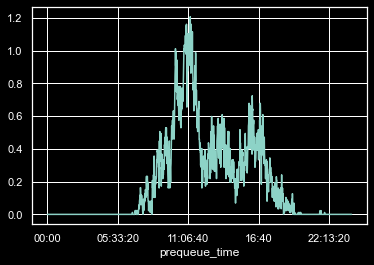

In [104]:
df_agent_avail_1min.groupby(df_agent_avail_1min['prequeue_time'].dt.time)['calls_in_queue'].mean().plot(kind='line')

Confirming the general trend where CL teams are busiest ~ 10 - 12 in the morning and 3-5 in the afternoon.

In [247]:
# Time-Series
df_agent_avail_1min_d = df_agent_avail_1min[df_agent_avail_1min['prequeue_time'].between('2021-10-03 06:00:00', '2021-11-06 22:00:00')][['prequeue_time', 'calls_in_queue']].copy(deep=True)
df_agent_avail_1min_d.set_index('prequeue_time', inplace=True)

In [145]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [166]:
plt.rc('figure', figsize=(20, 6))

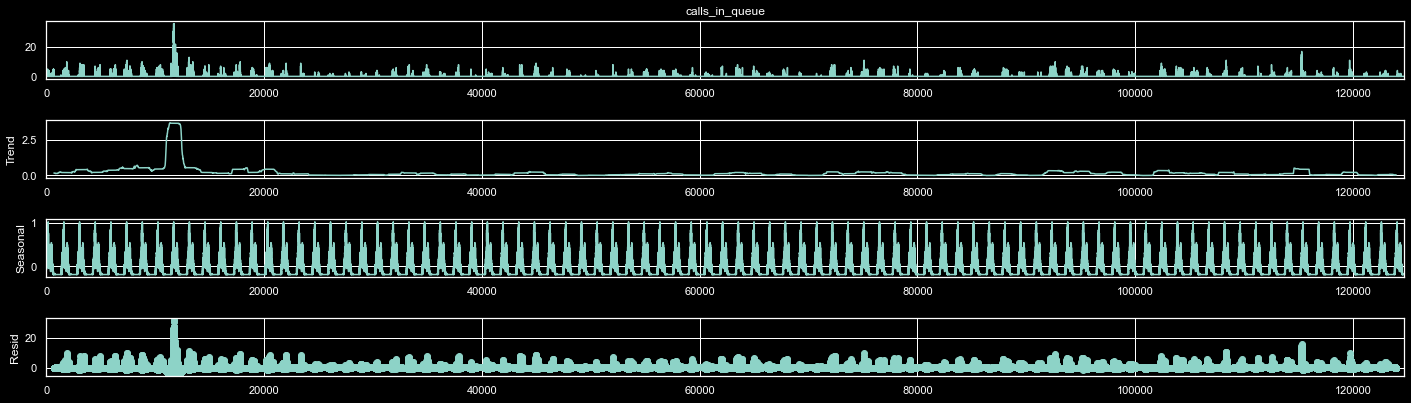

In [167]:
df_agent_avail_1min_d = df_agent_avail_1min[['prequeue_time', 'calls_in_queue']].copy(deep=True)

decompose = seasonal_decompose(df_agent_avail_1min_d['calls_in_queue'], model='additive', period=1440)

decompose.plot()
plt.show()

__Obervation__:
Pattern repeats daily, but doesn't seem to have a trend.

In [143]:
from statsmodels.graphics.tsaplots import plot_acf

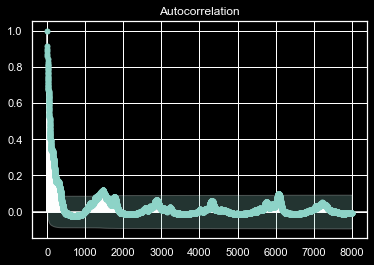

In [153]:
# ACF measures how a series is correlated with itself at different lags
plot_acf(df_agent_avail_1min_d['calls_in_queue'], lags=8000)
plt.show()
# 1440 is a day, correlation is < ~0.1 for a day apart. 

__Conclusion__:
Correlation is low. Predicting calls in queue is not promising. 

<a id='summary'> </a>

# Summary
- Teams are generally busiest during 10-12 AM and 3-5 PM.
- Half of the customers who abandoned in queue called CL back.
- Marketing cost for the lost calls is ~1k a day, not finding much value in automating PPC campaigns. 
- Predicting calls in queue with the current data is not promising. 